This notebook explores feature drift detection logic using a reference window and simulated monitoring windows. It is not production code.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

In [2]:
import numpy as np
import pandas as pd

In [3]:
MONITORING_REFERENCE_START = pd.to_datetime("2010-4-30")
MONITORING_REFERENCE_END = pd.to_datetime("2010-6-30")

WINDOW_TEST_START = pd.to_datetime("2011-11-30")
WINDOW_TEST_END = pd.to_datetime("2011-12-09")

MONITORING_WINDOW = 1  #1 month

MONITORED_FEATURES = ["Country" , "StockCode" , "Hour" , "Month" , "country_freq" , "stockcode_freq" , "InvoiceDate"]
NUMERIC_MONITORED_FEATURES = ["Hour" , "Month" , "country_freq" , "stockcode_freq"]

# Loading data

In [4]:
data = pd.read_csv("../data/processed/data.csv")
data = pd.DataFrame(data)
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data.head()

,Unnamed: 0,InvoiceDate,Country,StockCode,Year,Month,Day,Hour,min,sec,is_weekend,day_of_week,hour_sin,hour_cos,quarter,stockcode_freq,country_freq,target
0,0,2009-12-01 07:45:00,United Kingdom,0.453639,2009,12,1,7,45,0,0,1,0.965926,-0.258819,4,111,981330,1
1,1,2009-12-01 07:45:00,United Kingdom,0.539439,2009,12,1,7,45,0,0,1,0.965926,-0.258819,4,62,981330,1
2,2,2009-12-01 07:45:00,United Kingdom,0.538406,2009,12,1,7,45,0,0,1,0.965926,-0.258819,4,100,981330,1
3,3,2009-12-01 07:45:00,United Kingdom,0.364935,2009,12,1,7,45,0,0,1,0.965926,-0.258819,4,114,981330,1
4,4,2009-12-01 07:45:00,United Kingdom,0.204560,2009,12,1,7,45,0,0,1,0.965926,-0.258819,4,552,981330,1


In [5]:
print(data["InvoiceDate"].dtype)
print(type(MONITORING_REFERENCE_START))

datetime64[ns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
ref_mask = data["InvoiceDate"].between(MONITORING_REFERENCE_START, MONITORING_REFERENCE_END)
ref_mask

0          False
1          False
2          False
3          False
4          False
           ...  
1067366    False
1067367    False
1067368    False
1067369    False
1067370    False
Name: InvoiceDate, Length: 1067371, dtype: bool

In [7]:
data = data[MONITORED_FEATURES]
data.head()

,Country,StockCode,Hour,Month,country_freq,stockcode_freq,InvoiceDate
0,United Kingdom,0.453639,7,12,981330,111,2009-12-01 07:45:00
1,United Kingdom,0.539439,7,12,981330,62,2009-12-01 07:45:00
2,United Kingdom,0.538406,7,12,981330,100,2009-12-01 07:45:00
3,United Kingdom,0.364935,7,12,981330,114,2009-12-01 07:45:00
4,United Kingdom,0.204560,7,12,981330,552,2009-12-01 07:45:00


In [8]:
data.tail()

,Country,StockCode,Hour,Month,country_freq,stockcode_freq,InvoiceDate
1067366,France,0.101294,12,12,14330,93,2011-12-09 12:50:00
1067367,France,0.186403,12,12,14330,52,2011-12-09 12:50:00
1067368,France,0.143240,12,12,14330,53,2011-12-09 12:50:00
1067369,France,0.237943,12,12,14330,410,2011-12-09 12:50:00
1067370,France,0.679996,12,12,14330,442,2011-12-09 12:50:00


## Build Reference Baseline

In [9]:
ref_mask.unique()

array([False,  True])

In [10]:
# Getting reference data
X_ref = data[ref_mask].copy()
X_ref.head()

,Country,StockCode,Hour,Month,country_freq,stockcode_freq,InvoiceDate
180431,United Kingdom,0.268229,7,4,981330,305,2010-04-30 07:58:00
180432,United Kingdom,0.364965,7,4,981330,203,2010-04-30 07:58:00
180433,United Kingdom,0.619324,7,4,981330,356,2010-04-30 07:58:00
180434,United Kingdom,0.284319,7,4,981330,68,2010-04-30 07:58:00
180435,United Kingdom,0.194743,7,4,981330,390,2010-04-30 07:58:00


In [11]:
X_ref.drop(columns=["InvoiceDate"] , inplace= True)

In [12]:
X_ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74672 entries, 180431 to 255102
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         74672 non-null  object 
 1   StockCode       74672 non-null  float64
 2   Hour            74672 non-null  int64  
 3   Month           74672 non-null  int64  
 4   country_freq    74672 non-null  int64  
 5   stockcode_freq  74672 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.0+ MB


## Build a test window example

In [13]:
window_mask = data["InvoiceDate"].between(WINDOW_TEST_START, WINDOW_TEST_END)
window_mask.unique()

array([False,  True])

In [14]:
# Getting Window data
win_data = data[window_mask].copy()
win_data.head()

,Country,StockCode,Hour,Month,country_freq,stockcode_freq,InvoiceDate
1038391,United Kingdom,0.553361,8,11,981330,655,2011-11-30 08:04:00
1038392,United Kingdom,0.358955,8,11,981330,283,2011-11-30 08:04:00
1038393,United Kingdom,0.413478,8,11,981330,247,2011-11-30 08:04:00
1038394,United Kingdom,0.092127,8,11,981330,85,2011-11-30 08:04:00
1038395,United Kingdom,0.638086,8,11,981330,115,2011-11-30 08:04:00


In [15]:
win_data.drop(columns=["InvoiceDate"] , inplace=True)

In [16]:
def build_ks_reference(x_ref, quantiles=np.linspace(0.01, 0.99, 99)):
    return {
        "quantiles": quantiles,
        "values": np.quantile(x_ref, quantiles),
        "n_ref": len(x_ref)
    }


In [17]:
NUMERIC_MONITORED_FEATURES

ks_references = {}

for feature in NUMERIC_MONITORED_FEATURES:
    ks_references[feature] = build_ks_reference(
        X_ref[feature].values
    )




In [18]:
def approximate_ks(ref, x_prod):
    prod_cdf = np.mean(
        x_prod[:, None] <= ref["values"][None, :],
        axis=0
    )
    D = np.max(np.abs(prod_cdf - ref["quantiles"]))
    return D


In [19]:
ks_results = {}

for feature in NUMERIC_MONITORED_FEATURES:
    D = approximate_ks(
        ks_references[feature],
        win_data[feature].values
    )
    ks_results[feature] = D


if D > 0.1:
    alert = "strong drift"
elif D > 0.05:
    alert = "weak drift"
else:
    alert = "no drift"


In [20]:
ks_results

{'Hour': np.float64(0.13993820163089188),
 'Month': np.float64(0.99),
 'country_freq': np.float64(0.92),
 'stockcode_freq': np.float64(0.08649687351446228)}

In [21]:
alerts = {}

for feature, D in ks_results.items():
    if D > 0.1:
        alerts[feature] = "strong drift"
    elif D > 0.05:
        alerts[feature] = "weak drift"
    else:
        alerts[feature] = "no drift"

In [22]:
alerts

{'Hour': 'strong drift',
 'Month': 'strong drift',
 'country_freq': 'strong drift',
 'stockcode_freq': 'weak drift'}

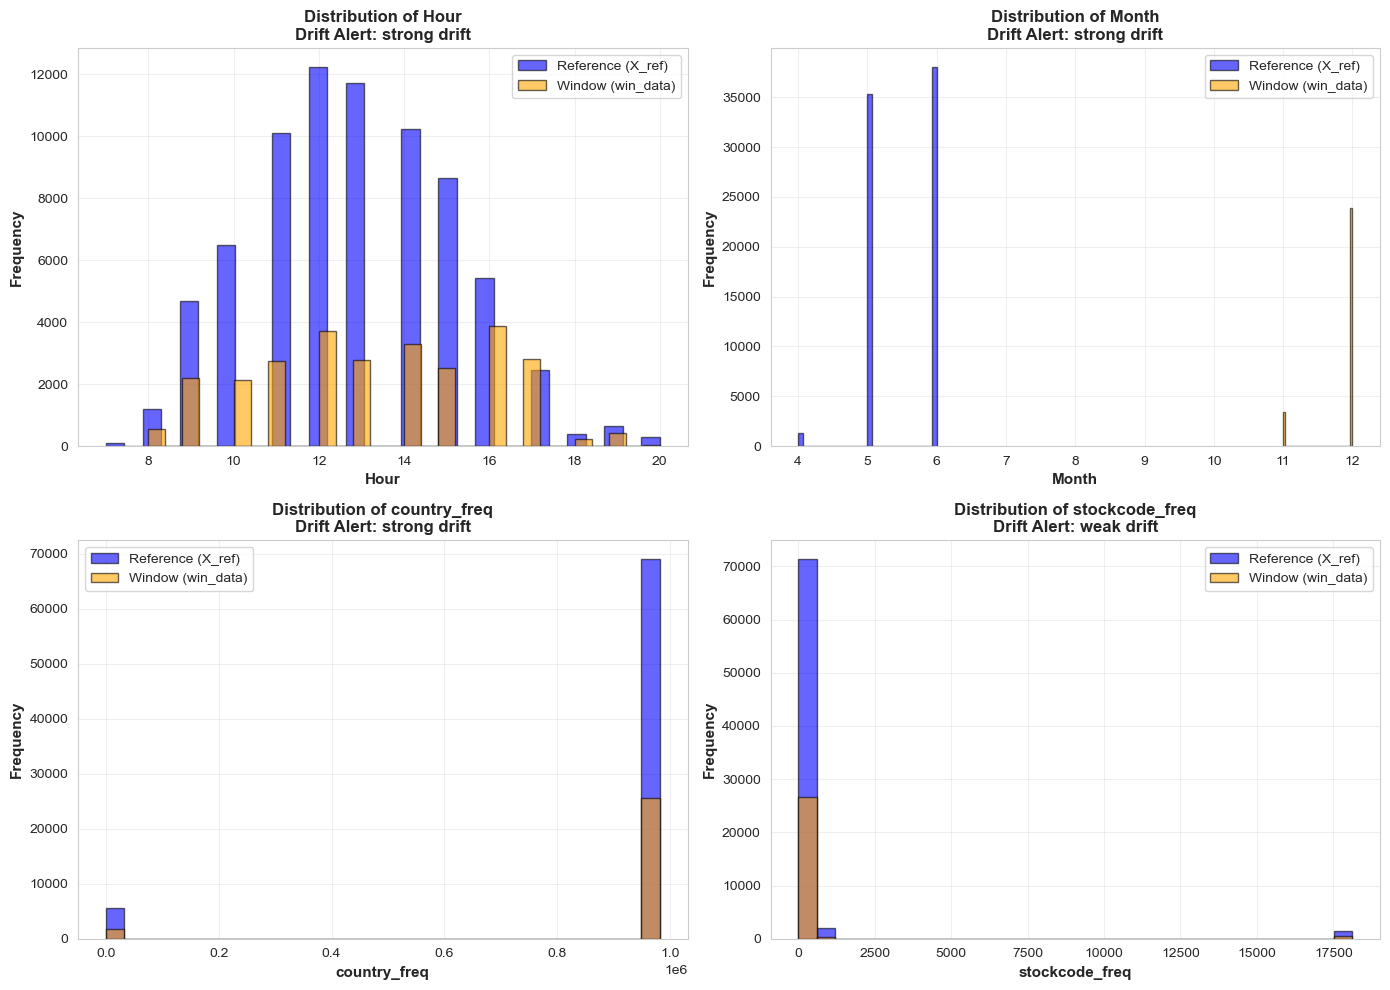

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots for each numeric feature
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(NUMERIC_MONITORED_FEATURES):
    ax = axes[idx]
    
    # Plot histograms for both datasets
    ax.hist(X_ref[feature], bins=30, alpha=0.6, label='Reference (X_ref)', color='blue', edgecolor='black')
    ax.hist(win_data[feature], bins=30, alpha=0.6, label='Window (win_data)', color='orange', edgecolor='black')
    
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'Distribution of {feature}\nDrift Alert: {alerts[feature]}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
import src.monitoring.drift as drift

In [25]:
ref = drift.build_ks_reference(X_ref[NUMERIC_MONITORED_FEATURES])

In [26]:
ks_results = drift.approximate_ks(ref , x_prod=win_data[NUMERIC_MONITORED_FEATURES])

In [27]:
alerts = {}

for feature, D in ks_results.items():
    if D > 0.1:
        alerts[feature] = "strong drift"
    elif D > 0.05:
        alerts[feature] = "weak drift"
    else:
        alerts[feature] = "no drift"

In [28]:
ks_results

{'Hour': np.float64(0.13993820163089188),
 'Month': np.float64(0.99),
 'country_freq': np.float64(0.92),
 'stockcode_freq': np.float64(0.08649687351446228)}

In [29]:
alerts

{'Hour': 'strong drift',
 'Month': 'strong drift',
 'country_freq': 'strong drift',
 'stockcode_freq': 'weak drift'}

In [30]:
rs = drift.feature_drift_detection(X_ref[NUMERIC_MONITORED_FEATURES] , NUMERIC_MONITORED_FEATURES , win_data[NUMERIC_MONITORED_FEATURES] , 0)

In [31]:
rs

{'Hour': 'strong drift',
 'Month': 'strong drift',
 'country_freq': 'strong drift',
 'stockcode_freq': 'weak drift'}